In [2]:
import numpy as np
import pandas as pd
import csv
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from pandas.plotting import scatter_matrix
from matplotlib import cm
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from numpy import inf
from sklearn.metrics.pairwise import cosine_similarity
import umap
import networkx as nx
import json
import pyreadr
import os
import ast
import obonet
import joblib
import scipy.stats as stats
import networkx as nx
#import pylatex
from sklearn.preprocessing import Normalizer
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
#import neo4j
from IPython.display import Latex
import torch
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
from collections import defaultdict
import numpy as np
from torch.nn import Linear
import torch.nn.functional as F
#from sentence_transformers import SentenceTransformer
#from neo4j import GraphDatabase
#import torch_geometric.transforms as T
#from torch_geometric.nn import SAGEConv, to_hetero
import gzip
#from torch_geometric.data import HeteroData
#from torch_geometric.transforms import ToUndirected, RandomLinkSplit
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve
#from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import random
%matplotlib inline

In [3]:
seed = 42

## INPUTS

In [24]:
gene_ftr = "../data/training/Gene.ftr"
phenotype_ftr = '../data/training/Phenotype.ftr'
phenotype_gene_tsv = "../data/training/genes_to_phenotype_map.txt"
HPO_solved = "/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/Rohan/src/HPO_Gene_solves_filtered_withHP.DotProduct.csv"
clinvar_gene_txt = '../data/training/clinvarGenes.txt'
link_prediction_ftr_dir = "../link_prediction/"


gene_list_df = pd.read_csv(clinvar_gene_txt, sep='\t')
probability_table_mayo_df = pd.read_csv("../data/training/probabilities.csv")
probability_table_PCAN_df = pd.read_csv("../data/training/PCAN_IC_normalized.csv")
gene_list_df = pd.read_csv("../data/training/clinvarGenes.txt")

ckg_hpo_count_df = pd.read_csv("../data/training/ClinVar_genes_HPO_connected_ckg.cv")
ckg_hpo_count_df.columns = ['GENE', 'HPO']
total_genes = len(set(ckg_hpo_count_df.GENE.tolist()))
total_HPO = len(set(ckg_hpo_count_df.HPO.tolist()))
ckg_gene_prob_df = ckg_hpo_count_df.groupby(['GENE']).count().reset_index()
ckg_phenotype_prob_df = ckg_hpo_count_df.groupby(['HPO']).count().reset_index()

ckg_gene_prob_df['PROBABILITY'] = ckg_gene_prob_df['HPO']/int(total_HPO)
ckg_phenotype_prob_df['PROBABILITY'] = ckg_phenotype_prob_df['GENE']/int(total_genes)
ckg_gene_prob_df = ckg_gene_prob_df[['GENE', 'PROBABILITY']]
ckg_phenotype_prob_df = ckg_phenotype_prob_df[['HPO', 'PROBABILITY']]
ckg_gene_prob_df = ckg_gene_prob_df.sort_values(by="PROBABILITY", ascending=False)
ckg_gene_prob_df = ckg_gene_prob_df.reset_index(drop=True)
probability_ckg_df = ckg_phenotype_prob_df.sort_values(by="PROBABILITY", ascending=False)
probability_ckg_df = ckg_phenotype_prob_df.reset_index(drop=True)
#ckg_hpo_count_df = ckg_hpo_count_df[['count', 'HPO']]
#ckg_hpo_count_df['PROBABILITIES'] = ckg_hpo_count_df['count']/len(gene_list_df)
#
#ckg_hpo_count_df

#probability_ckg_df = ckg_hpo_count_df.copy()
#probability_ckg_df = probability_ckg_df[["HPO", "PROBABILITIES"]]

#ckg_gene_prob_df[ckg_gene_prob_df['GENE'] == "ERCC6L2"]
probability_ckg_df

,HPO,PROBABILITY
0,HP:0000002,0.004901
1,HP:0000003,0.029403
2,HP:0000006,0.420582
3,HP:0000007,0.649178
4,HP:0000008,0.013549
...,...,...
8596,HP:3000005,0.000577
8597,HP:3000037,0.000577
8598,HP:3000038,0.000288
8599,HP:3000050,0.000288


<AxesSubplot:ylabel='Count'>

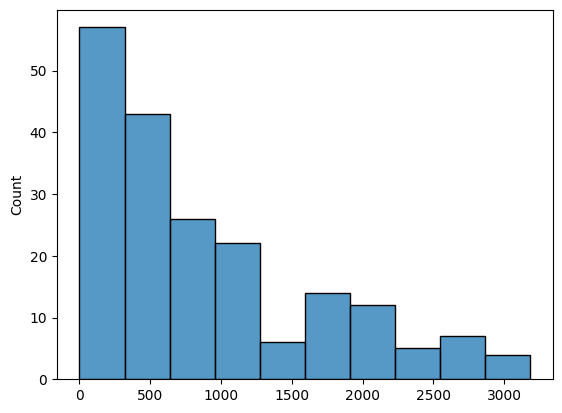

In [5]:
solved_out_df = pd.read_csv(HPO_solved) 
solved_out_df = solved_out_df[['Normalized ID', 'Gene1', 'HPO']]
solved_out_df.columns = ['SL2_ID', 'Gene', 'Phenotype']
solved_gene_phen_df = solved_out_df[['Gene', 'Phenotype']]
solved_gene_phen_df['Phenotype'] = solved_gene_phen_df['Phenotype'].str.split(',')
solved_gene_phen_df = solved_gene_phen_df.explode('Phenotype')
solved_gene_phen_df = solved_gene_phen_df.dropna()
solved_gene_phen_df = solved_gene_phen_df.reset_index(drop=True)
solved_gene_phen_df.to_csv("../data/training/gene_phenotype_solved.tsv", index=None, sep='\t')
solved_genes_list = solved_out_df.Gene.tolist()
solved_HPO_list = list(set(solved_gene_phen_df.Phenotype.tolist()))
solved_gene_phen_df
#solved_HPO_list
sns.histplot(ckg_gene_prob_df[ckg_gene_prob_df['GENE'].isin(solved_genes_list)].index)



<AxesSubplot:ylabel='Count'>

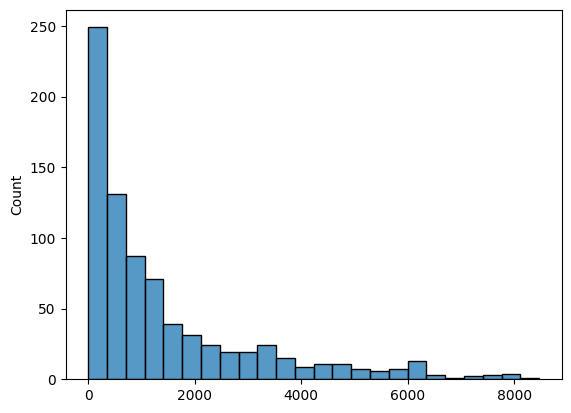

In [6]:
sns.histplot(ckg_phenotype_prob_df[ckg_phenotype_prob_df['HPO'].isin(solved_HPO_list)].index)

### Loading the embedding and preprocessing the data

In [7]:
def filter_row_emb(x):
    if all(v == 0 for v in x):
        return 1
    else:
        return 0
    

def load_parse_ftr(ftr_file, node_name):
    df = pd.read_feather(ftr_file)
    
    column_name_dict = {
        'ID(n)': 'ID',
        'labels(n)': 'labels',
        'n.`fastrp-embedding`': 'fastrp_embedding',
        'n.description': 'description',
        'n.id': 'id',
        'n.name': 'name',
        'n.synonyms': 'synonyms',
        'n.type': 'type'
    }
    
    df = df.rename(columns=column_name_dict)
    
    df['fastrp_embedding'] = df['fastrp_embedding'].values
    df['keep'] = df['fastrp_embedding'].apply(filter_row_emb)
    df = df[df['keep'] == 0]
    df = df.reset_index(drop=True)
    
    data_df = df[['id', 'fastrp_embedding']]
    embedding_column = 'fastrp_embedding_' + node_name
    data_df.columns = [node_name, embedding_column]
    
    return data_df
    

### Loading the mapping files

In [8]:
def mapping_data(mapping_file, node_name1, node_name2):
    df =  pd.read_csv(mapping_file, header=0, sep='\t', quotechar='"', error_bad_lines=False)
    df = df[['START_ID', 'END_ID']]
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    df.columns = [node_name1, node_name2]
    df['labels'] = 1
    df['map'] = df[node_name1] + '_' + df[node_name2]
    return df
    


### Generating data table with connected nodes

In [9]:
class GenerateData:
    def __init__(self, phen_df, map_df, gene_df, val_df, total_links=120000, total_unlink_pairs=26, total_datapoints=80000):
        self.phen_df = phen_df
        self.map_df = map_df
        self.gene_df = gene_df
        self.val_df = val_df
        self.total_links = total_links
        self.total_unlink_pairs = total_unlink_pairs
        self.total_datapoints = total_datapoints
    
    def create_linked_df(self):
        df = pd.merge(self.phen_df, self.map_df, on='Phenotype', how='left')
        df = df[~df['Gene'].isna()]
        df = pd.merge(df, self.gene_df, on='Gene', how='left')
        df = df.dropna(subset=['fastrp_embedding_Gene', 'fastrp_embedding_Phenotype'])
        df = df.sample(n=self.total_links, random_state=seed).reset_index(drop=True)
        print(df.shape)
        return df
    
    def create_unlinked_df(self):
        gene_phen_dict = defaultdict(list)
        unique_ids = self.map_df['Phenotype'].unique().tolist()
        phen_gene_dict = self.map_df.groupby('Gene')['Phenotype'].agg(list).to_dict()
        for key, value in phen_gene_dict.items():
            non_connected_hp = list(set(unique_ids) - set(value))
            if len(non_connected_hp) < self.total_unlink_pairs:
                gene_phen_dict[key] = non_connected_hp
            else:
                non_connected_hp = random.sample(non_connected_hp, self.total_unlink_pairs)
                gene_phen_dict[key] = non_connected_hp
        phen_gene_nolink_df = pd.DataFrame.from_dict(gene_phen_dict, orient='index').stack().reset_index()
        phen_gene_nolink_df.columns = ['Gene', 'level_1', 'Phenotype']
        phen_gene_nolink_df = phen_gene_nolink_df.drop('level_1', axis=1)
        df = pd.merge(phen_gene_nolink_df, self.phen_df, on='Phenotype', how='left')
        df = pd.merge(df, self.gene_df, on='Gene', how='left')
        df['labels'] = 0
        df = df.dropna(subset=['fastrp_embedding_Gene', 'fastrp_embedding_Phenotype'])
        df = df.reset_index(drop=True)
        train_df, val_df = train_test_split(df, test_size=0.02, random_state=42)
        print(train_df.shape)
        return  train_df, val_df
    
    def process_val_data(self):
        test_data, val_data = self.create_unlinked_df()
        print("val data shape {0}".format(val_data.shape))
        #val_data = val_data.drop(['labels'], axis=1)
        self.val_df.columns = ['SL2_ID', 'Gene', 'Phenotype']
        self.val_df['Phenotype'] = self.val_df['Phenotype'].astype(str).str.split(',')
        self.val_df = self.val_df.explode('Phenotype')
        self.val_df = self.val_df.drop(['SL2_ID'], axis=1)
        #print(self.val_df)
        solved_gene_df = pd.merge(self.val_df, self.gene_df, on='Gene', how='left')
        #print(solved_gene_df)
        solved_gene_pheno_df = pd.merge(solved_gene_df, self.phen_df, on='Phenotype', how='left')
        genes_removed = set(solved_gene_pheno_df[solved_gene_pheno_df['fastrp_embedding_Gene'].isna()]['Gene'])
        phenotype_removed = set(solved_gene_pheno_df[solved_gene_pheno_df['fastrp_embedding_Phenotype'].isna()]['Phenotype'])
        solved_gene_pheno_df = solved_gene_pheno_df.dropna(subset=['fastrp_embedding_Gene', 'fastrp_embedding_Phenotype'])
        solved_gene_pheno_df = solved_gene_pheno_df.reset_index(drop=True)
        solved_gene_pheno_df['labels'] = 1
        validation_df = pd.concat([solved_gene_pheno_df, val_data])
        validation_df = validation_df.reset_index(drop=True)
        #validation_df = validation_df.drop(['SL2_ID'], axis=1)
        return validation_df

    
    def get_data(self):
        train_data, val_data_neg = self.create_unlinked_df()
        data_df = pd.concat([self.create_linked_df(), train_data])
        data_df['labels'] = data_df['labels'].astype(int)
        data_df =  data_df.drop(['map'], axis=1)
        val_data_pos = self.process_val_data()
        #val_data_phenotypes = self.process_val_data()['Phenotype']
        val_data_genes = list(set(val_data_pos['Gene'].tolist()))
        val_data_phenotypes = list(set(val_data_pos['Phenotype'].tolist()))
        #data_df = data_df[~data_df['Gene'].isin(val_data_genes)]
        print(data_df.shape)
        #data_df = data_df[~data_df['Phenotype'].isin(val_data_phenotypes)]
        data_test_df = data_df.copy()
        data_test_df = data_df.sample(n=self.total_datapoints)
        data_test_df = data_test_df.reset_index(drop=True)
        data_df['fastrp_embedding_Gene'] = data_df['fastrp_embedding_Gene'].tolist()
        data_df['fastrp_embedding_Phenotype'] = data_df['fastrp_embedding_Phenotype'].tolist()
        return data_test_df, data_df
    
    

### Generating data table for non-connected nodes

In [10]:
class Operations(object):
    
    def __init__(self, emb1, emb2):
        self.emb1 = emb1
        self.emb2 = emb2
    
    def __iter__(self):
        return self
    
    
    def embeddings1(self):
        return self.emb1
    
    def embeddings2(self):
        return self.emb2
    
    def average(self):
        df1_embedding = np.array(self.embeddings1().tolist())
        df2_embedding = np.array(self.embeddings2().tolist())
        x = df1_embedding + np.resize(df2_embedding, df1_embedding.shape)
        return x/2
        
    def euclidean_distance(self):
        df1_embedding = self.embeddings1()
        df2_embedding = self.embeddings2()
        x = np.linalg.norm(df1_embedding.tolist() - np.transpose(df2_embedding.tolist()))
        return x
        
    def Hadamard(self):
        df1_embedding = np.array(self.embeddings1().tolist())
        df2_embedding = np.array(self.embeddings2().tolist())
        x = df1_embedding * df2_embedding
        return x
        
    def L1(self):
        df1_embedding = np.array(self.embeddings1().tolist())
        df2_embedding = np.array(self.embeddings2().tolist())
        x = df1_embedding - np.resize(df2_embedding, df1_embedding.shape)
        return abs(x)
    
    def L2(self):
        df1_embedding = np.array(self.embeddings1().tolist())
        df2_embedding = np.array(self.embeddings2().tolist())
        x = df1_embedding - np.resize(df2_embedding, df1_embedding.shape)
        y = abs(x)
        y = np.square(y)
        return y

### Final data to use

In [11]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_recall_curve, auc

def calculate_confidence_interval(data, metric, n_bootstraps=1000, alpha=0.95):
    bootstrapped_metrics = []
    for _ in range(n_bootstraps):
        bootstrapped_data = resample(data, random_state=np.random.seed())
        print(bootstrapped_data)
        print(metric)
        metric_value = metric(bootstrapped_data)
        bootstrapped_metrics.append(metric_value)
    
    lower_percentile = (1.0 - alpha) / 2.0 * 100
    upper_percentile = 100 - lower_percentile
    lower_bound = np.percentile(bootstrapped_metrics, lower_percentile)
    upper_bound = np.percentile(bootstrapped_metrics, upper_percentile)
    
    return metric, lower_bound, upper_bound






## Analysis

In [12]:
gene_df = load_parse_ftr(gene_ftr, "Gene")
phenotype_df =  load_parse_ftr(phenotype_ftr, "Phenotype")
solved_df = pd.read_csv(HPO_solved, sep='\t', header=None) 
phen_gene_df = mapping_data(phenotype_gene_tsv, "Gene", "Phenotype")

positive_label_list = list(set(phen_gene_df.map.to_list()))




In [13]:

from pylatex import Document, Section, Subsection, Command


doc = Document()

# Add text
doc.append(Command('text', 'Let $E_{g}$ be the embedding for the gene nodes and $E_{p}$ be the embedding for the phenotype node.'))
doc.append('')

doc.append(Command('textbf', 'Hadamard'))
doc.append(' ')
doc.append('$(E_{g}, E_{p}) = f(E_{g}) \\cdot f(E_{p})$')
doc.append('')

doc.append(Command('textbf', 'Average'))
doc.append(' ')
doc.append('$(E_{g}, E_{p}) = \\frac{f(E_{g}) + f(E_{p})}{2}$')
doc.append('')

doc.append(Command('textbf', 'L1'))
doc.append(' ')
doc.append('$(E_{g}, E_{p}) = |f(E_{g}-f(E_{t})|$')
doc.append('')

doc.append(Command('textbf', 'L2'))
doc.append(' ')
doc.append('$(E_{g}, E_{p}) = |f(E_{g}-f(E_{t})|^2$')

print(doc)

#doc.generate_pdf('equations', clean_tex=False, compiler='pdflatex')


Document('default_filepath', [Command('normalsize', Arguments(), Options()), Command('text', Arguments('Let $E_{g}$ be the embedding for the gene nodes and $E_{p}$ be the embedding for the phenotype node.'), Options()), '', Command('textbf', Arguments('Hadamard'), Options()), ' ', '$(E_{g}, E_{p}) = f(E_{g}) \\cdot f(E_{p})$', '', Command('textbf', Arguments('Average'), Options()), ' ', '$(E_{g}, E_{p}) = \\frac{f(E_{g}) + f(E_{p})}{2}$', '', Command('textbf', Arguments('L1'), Options()), ' ', '$(E_{g}, E_{p}) = |f(E_{g}-f(E_{t})|$', '', Command('textbf', Arguments('L2'), Options()), ' ', '$(E_{g}, E_{p}) = |f(E_{g}-f(E_{t})|^2$'])


\documentclass{article}
\begin{document}


Let $E_{g}$ be the embedding for the gene nodes, and \\\
$E_{p}$ be the embedding for the phenotype node:

Hadamard $(E_{g}, E_{p}) = f(E_{g}) \cdot f(E_{p})$

Average $(E_{g}, E_{p}) = \frac{f(E_{g}) + f(E_{p})}{2}$

L1 $(E_{g}, E_{p}) = |f(E_{g}-f(E_{t})|$

L2 $(E_{g}, E_{p}) = |f(E_{g}-f(E_{t})|^2$

Cosine similarity:

Cosine Similarity$ = \frac{E_{g}^T \cdot E_{p}} {|E_{g}| \cdot |E_{p}|}$


Where $E_{g}^T$ is the transpose of embedding \\\
for gene nodes, and $E_{p}$ is the embedding \\\
for the phenotype node.


Dot Product$ = {E_{g}^T \cdot E_{p}} $


$IC_{p}$$ = \frac {N_{P}}{N}$

Where $N_{P}$ is the number of genes connected to the \\\
phenotye and $N$ is the total number of genes


Rank $= max(\sum_{p=1}^{n} $$\vec{h}$)


For all phenotypes $p$ for a given case $i$:

$\vec{h}$$ = -log_{2}(g|p) \cdot IC_{P} \cdot w_{p}$

$Rank$$ = \max(\sum $$\vec{h}$)

where $\vec{h}$ is the dot product of the negative log of &nbsp;&nbsp; &nbsp; \\\
the probablity measure from cosinse similarity,      &nbsp;&nbsp;&nbsp; \\\
Information content and the weighted coefficients             \\\
from link predictions for all given phenotypes 

 

\end{document}


###### MODEL

In [14]:
class RankQuery:
    def __init__(self, gene_df, phenotype_df, prob_df):
        self.gene_df = gene_df
        self.phenotype_df = phenotype_df
        self.prob_df = prob_df

    def embeddings1(self):
        return self.gene_df.fastrp_embedding_Gene.values

    def embeddings2(self):
        return self.phenotype_df.fastrp_embedding_Phenotype.values

    def dot_product(self):
        df1_embedding = self.embeddings1()
        df2_embedding = self.embeddings2()
        x = np.matmul(df1_embedding.tolist(), np.transpose(df2_embedding.tolist()))  # shape(15872, 3564)
        return x

    def cosine_similarity(self):
        df1_embedding = np.array(self.embeddings1().tolist())
        df2_embedding = np.array(self.embeddings2().tolist())
        x = cosine_similarity(df1_embedding, df2_embedding)  # shape(15872, 3564)
        return x

    def get_probability(self, query):
        try:
            probability = self.prob_df[self.prob_df['HPO'] == query]['PROBABILITIES'].values[0]
            return probability
        except IndexError:
            print("HPO {0} not found in the list of probabilities".format(query))
            return min(self.prob_df['PROBABILITIES'])

    def log_probability(self, query):
        try:
            probability = self.get_probability(query)
            log_probs = -math.log2(probability)
            return log_probs
        except TypeError:
            print("HPO {0} not found in the list of probabilities".format(query))
            exit()


    @staticmethod
    def stable_softmax(x):
        z = x - np.max(x,axis=1)[:,np.newaxis]
        numerator = np.exp(z)
        denominator = np.sum(numerator,axis=1)
        softmax = numerator/denominator[:,np.newaxis]
        return softmax

    def execute_softmax(self):
        #print(np.shape(self.inndot_product()))
        softmax = RankQuery.stable_softmax(self.dot_product())
        return softmax
    

    def create_dataframe_cosine(self):
        prob_table_df = self.prob_df.set_index('HPO')
        rownames = self.gene_df.Gene
        columns_order = self.phenotype_df.Phenotype.to_frame()
        columns_df = self.phenotype_df.Phenotype.to_frame().set_index('Phenotype')
        columns_df = columns_df.join(prob_table_df)
        columns_df = columns_df.fillna(np.nanmin(columns_df.to_numpy()))
        columns_df = columns_df.reindex(columns_order.Phenotype)
        finalmat = self.cosine_similarity()/columns_df.to_numpy().T
        #finalmat = self.cosine_similarity()
        final_df = pd.DataFrame(data=finalmat, index = rownames, columns=columns_order.Phenotype)
        return final_df
    
    def create_dataframe_dp(self):
        prob_table_df = self.prob_df.set_index('HPO')
        rownames = self.gene_df.Gene
        columns_order = self.phenotype_df.Phenotype.to_frame()
        columns_df = self.phenotype_df.Phenotype.to_frame().set_index('Phenotype')
        columns_df = columns_df.join(prob_table_df)
        columns_df = columns_df.fillna(np.nanmin(columns_df.to_numpy()))
        columns_df = columns_df.reindex(columns_order.Phenotype)
        finalmat = self.dot_product()/columns_df.to_numpy().T
        final_df = pd.DataFrame(data=finalmat, index = rownames, columns=columns_order.Phenotype)
        return final_df


In [15]:
class BayesRank(object):
    
    def __init__(self, phenotype_df, gene_df, prob_df):
        self.phenotype_df = phenotype_df # phenotype (hpo id and fastrp embedding)
        self.gene_df = gene_df # gene (gene id and fastrp embedding)
        self.prob_df = prob_df # probability (hpo_id and hpo_prob)
        #self.filter_df = filter_df
        #self.hpo_set = set(hpo_df.hpo_id.values)
        #self.gene_set = set(gene_df.gene_id.values)

    def inndot_product(self):
        df1_embedding = self.gene_df.fastrp_embedding_Gene.values
        df2_embedding = self.phenotype_df.fastrp_embedding_Phenotype.values #shape(15872, 3564)
        x = np.matmul(df1_embedding.tolist(), 
                         np.transpose(df2_embedding.tolist()))
        #x = preprocessing.normalize(x, norm='l2',axis=0)
        #Data_normalized = Data_normalizer.transform(array)
        return x
    
    @staticmethod
    def stable_softmax(x):
        z = x - np.max(x,axis=1)[:,np.newaxis]
        numerator = np.exp(z)
        denominator = np.sum(numerator,axis=1)
        softmax = numerator/denominator[:,np.newaxis]
        return softmax
    
    def execute_softmax(self):
        #print(np.shape(self.inndot_product()))
        softmax = BayesRank.stable_softmax(self.inndot_product())
        return softmax
    
    def create_dataframe(self):
        prob_table_df = self.prob_df.set_index('HPO')
        rownames = self.gene_df.Gene
        columns_order = self.phenotype_df.Phenotype.to_frame()
        columns_df = self.phenotype_df.Phenotype.to_frame().set_index('Phenotype')
        columns_df = columns_df.join(prob_table_df)
        columns_df = columns_df.fillna(np.nanmin(columns_df.to_numpy()))
        columns_df = columns_df.reindex(columns_order.Phenotype)
        #print(columns_df)
        #print(self.execute_softmax())
        #finalmat = np.log(self.execute_softmax()/columns_df.to_numpy().T)
        #finalmat = self.execute_softmax()
        finalmat = self.execute_softmax()/columns_df.to_numpy().T
        final_df = pd.DataFrame(data=finalmat, index = rownames, columns=columns_order.Phenotype)
        return final_df
    
    

def predict_rank(df, model_df, phenotype_list):
    rank_dict = defaultdict(list)
    for i, j in df.iterrows():
        HPO_list = j['HPO'].strip().split(",")
        total_count = len(HPO_list)
        gene = df['Gene'][i]
        filter_HPO = list(set(HPO_list).intersection(phenotype_list))
        result_df = pd.DataFrame(model_df[filter_HPO])
        result_max_df = pd.DataFrame(result_df.max(axis=1), columns=['MaxValue']).sort_values(by='MaxValue', ascending=False).reset_index()
        result_mean_df = pd.DataFrame(result_df.mean(axis=1), columns=['MeanValue']).apply(lambda x: x/len(filter_HPO)).sort_values(by='MeanValue', ascending=False).reset_index()
        rank_max = result_max_df[result_max_df['Gene'] == gene].index[0]
        rank_mean = result_mean_df[result_mean_df['Gene'] == gene].index[0]
        rank_dict[gene].append({'rank_max': rank_max +1, 'rank_mean': rank_mean +1})
    return rank_dict
        
        #rank_bayes = bm_df.index[bm_df['id'] == df['Gene1'][i]].tolist()

In [16]:
def stable_softmax(x):
    z = x - np.max(x,axis=1)[:,np.newaxis]
    numerator = np.exp(z)
    denominator = np.sum(numerator,axis=1)
    softmax = numerator/denominator[:,np.newaxis]
    return softmax

In [17]:
def stack_results(data, phen_df, gene_df):
    df = pd.DataFrame(np.vstack(data))
    rownames = phen_df.id
    colnames = gene_df.id
    df.columns = colnames
    df['Phenotype'] = rownames
    melt_df = pd.melt(df, id_vars='Phenotype')
    return melt_df

# PREPROCESSING

In [18]:
def parse_link_prediction(ftr_dir):
    dfs = []
    for filename in os.listdir(ftr_dir):
        if filename.endswith('.ftr'):
            filepath = os.path.join(ftr_dir, filename)
            df = pd.read_feather(filepath)
            dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

In [19]:
#link_prediction_df = parse_link_prediction(link_prediction_ftr_dir)
#link_prediction_req_df = link_prediction_df[['Gene', 'Phenotype', 'probabilities']]
#link_prediction_req_df = link_prediction_req_df.drop_duplicates()
#link_prediction_req_df = link_prediction_req_df.reset_index()
#link_prediction_req_wide_df = link_prediction_req_df.pivot(index='Gene', columns='Phenotype', values='probabilities')
#link_prediction_req_wide_df = link_prediction_req_wide_df.reset_index()
#link_prediction_req_wide_df.to_csv("../data/training/link_prediction_L2_mlp.csv")
link_prediction_req_wide_df = pd.read_csv("../data/training/link_prediction_L2_mlp.csv")
link_prediction_req_wide_df = link_prediction_req_wide_df.drop(link_prediction_req_wide_df.columns[0], axis=1)
link_prediction_req_wide_df

,Gene,HP:0000002,HP:0000003,HP:0000006,HP:0000007,HP:0000008,HP:0000009,HP:0000010,HP:0000011,HP:0000012,...,HP:0500243,HP:0500253,HP:0500262,HP:0500270,HP:0550004,HP:3000005,HP:3000037,HP:3000038,HP:3000050,HP:3000062
0,A4GALT,2.217363e-02,0.999981,1.000000,1.000000,9.999896e-01,1.270350e-02,9.960871e-01,3.070835e-01,0.999924,...,3.457111e-16,2.959353e-16,5.213940e-12,1.304149e-12,7.755487e-10,3.273510e-12,6.226296e-16,1.757292e-10,1.615639e-09,3.903453e-01
1,AAAS,9.986240e-01,1.000000,1.000000,1.000000,7.651286e-02,1.017263e-01,9.055139e-01,7.233641e-02,0.013317,...,3.437434e-14,2.533925e-14,5.118919e-09,1.300873e-14,4.830359e-16,3.417190e-13,8.946594e-18,7.351041e-06,2.378880e-08,1.756225e-04
2,AARS2,9.220662e-11,0.999288,1.000000,0.999999,8.783700e-01,1.746958e-10,5.673874e-06,7.761572e-05,0.000001,...,5.529162e-18,1.034227e-13,3.057154e-10,3.102445e-16,1.801608e-14,1.267227e-13,1.228812e-13,3.025299e-16,4.577358e-11,1.626862e-06
3,AASS,1.256442e-05,0.991503,1.000000,1.000000,1.474176e-07,1.513496e-10,9.999126e-01,1.334555e-01,0.000003,...,9.999908e-01,5.375788e-17,4.847073e-14,3.682395e-16,2.106222e-07,1.241530e-10,2.901296e-15,3.992526e-15,4.901159e-10,5.904405e-13
4,ABAT,9.996296e-01,1.000000,1.000000,1.000000,4.006697e-04,1.578309e-04,9.542825e-01,1.468138e-02,0.007054,...,6.696407e-16,4.265170e-19,1.152174e-03,3.763041e-18,2.312750e-12,3.266592e-16,4.451172e-12,1.068695e-15,2.232253e-12,4.228908e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3464,ZNF750,2.040569e-04,0.994725,1.000000,1.000000,1.268388e-05,1.426087e-05,9.999806e-01,9.993500e-01,0.368686,...,3.025641e-17,2.037303e-18,1.053008e-11,1.028391e-18,6.273306e-16,3.519416e-08,7.833064e-16,2.262721e-16,6.805467e-12,3.997468e-10
3465,ZNHIT3,4.881875e-06,1.000000,0.999993,1.000000,3.355447e-10,5.488498e-05,8.952385e-09,4.672130e-10,0.001096,...,2.437441e-17,1.813202e-17,9.393758e-11,7.862323e-13,2.154872e-14,1.549459e-06,9.397400e-16,2.944698e-13,5.035394e-14,2.746087e-12
3466,ZP1,9.994172e-01,0.999246,1.000000,1.000000,9.896281e-01,6.720917e-09,9.999779e-01,7.940578e-09,0.000134,...,2.684324e-15,1.488177e-13,8.754813e-13,1.712325e-15,2.795018e-13,1.851780e-11,1.176931e-16,2.035532e-19,8.305419e-05,2.384667e-11
3467,ZP3,3.452825e-03,1.000000,1.000000,0.999996,9.999811e-01,2.673112e-03,9.999935e-01,6.613456e-01,0.000009,...,1.313476e-12,4.486303e-05,1.769282e-02,3.429551e-19,8.982274e-11,1.248080e-05,8.758019e-12,9.306217e-13,9.386529e-08,1.187397e-01


In [90]:
linked_genes_list = link_prediction_req_wide_df.Gene.tolist()
linked_phenotype_list = link_prediction_req_wide_df.columns.tolist()
linked_phenotype_list = linked_phenotype_list[1:]
with open('../results/Global_HPO.list', 'w+') as fout:
    for i in linked_phenotype_list:
        fout.write(i + '\n')

In [25]:
phenotype_df = pd.read_feather(phenotype_ftr)
gene_df = pd.read_feather(gene_ftr)
solved_df = pd.read_csv(HPO_solved)
gene_list = gene_list_df['CLINVAR_GENES'].tolist()
#clinvar_genes_df = pd.read_csv()
#gene_list_df
#test_df = pd.read_csv("/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/Rohan/data/HPO_Gene_solves_filtered_withHP.test.txtd", delimiter='\t')
#test_gdf = pd.read_csv("/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/Rohan/data/HPO_Gene_solves_filtered_withHP.test.txtd", delimiter='\t')
#solved_df= pd.read_csv("/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/Rohan/src/solved_cases.csv")
#filter_gene_df =pd.read_csv("/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/data/CKG/withNewEdgesGenePhenoDisease/version2/GenesWithEdges.csv")
colum_name_dict = { 'ID(n)':'ID', 
              'labels(n)':'labels', 
              'n.`fastrp-embedding`':'fastrp_embedding', 
              'n.description':'description',
              'n.id':'id', 
              'n.name':'name', 
              'n.synonyms':'synonyms', 
              'n.type':'type'}

phenotype_new_df = phenotype_df.rename(columns=colum_name_dict)
gene_new_df = gene_df.rename(columns=colum_name_dict)

#test_solved_df = pd.merge(solved_df, test_df, on=['Original ID'], how='left')
#HPO_terms_set = set(phenotype_new_df['id'].tolist())

gene_new_clinvar_df = gene_new_df[gene_new_df['id'].isin(gene_list)].reset_index(drop=True)
gene_new_clinvar_df = gene_new_clinvar_df[gene_new_clinvar_df['id'].isin(linked_genes_list)]
gene_new_clinvar_df = gene_new_clinvar_df.reset_index(drop=True)
gene_new_clinvar_df = gene_new_clinvar_df[['id', 'fastrp_embedding']]
gene_new_clinvar_df.columns = ['Gene', 'fastrp_embedding_Gene']

phenotype_new_df = phenotype_new_df[phenotype_new_df['id'].isin(linked_phenotype_list)]
phenotype_new_df = phenotype_new_df[['id', 'fastrp_embedding']]
phenotype_new_df.columns = ['Phenotype', 'fastrp_embedding_Phenotype']
probability_ckg_filtered_df = probability_ckg_df[probability_ckg_df['HPO'].isin(linked_phenotype_list)]
#linked_phenotype_list
#filter_gene_list = list(set(filter_gene_df['n.id'].tolist()))


probability_ckg_filtered_df
probability_PCAN_filtered_df = probability_table_PCAN_df[probability_table_PCAN_df['HPO'].isin(probability_ckg_filtered_df.HPO.tolist())]
probability_PCAN_filtered_df

,HPO,PROBABILITIES
1,HP:0000002,0.795232
2,HP:0000003,0.752422
7,HP:0000006,0.000541
15,HP:0000007,0.000541
18,HP:0000008,0.590463
...,...,...
19407,HP:3000005,0.000541
19439,HP:3000037,0.000541
19440,HP:3000038,0.000541
19452,HP:3000050,0.000541


In [26]:
bayes_model = BayesRank(phenotype_new_df, gene_new_clinvar_df, probability_ckg_filtered_df)
dp_cosine_model = RankQuery(gene_new_clinvar_df, phenotype_new_df,probability_ckg_filtered_df)
bayes_df = bayes_model.create_dataframe()
cs_df = dp_cosine_model.create_dataframe_cosine()
dp_df = dp_cosine_model.create_dataframe_dp()
#run_methods(test_df, bayes_df, dp_cosine_model, probability_ckg_df)  


In [88]:
link_prediction_req_wide_index_df = link_prediction_req_wide_df.copy()
link_prediction_req_wide_index_df = link_prediction_req_wide_index_df.set_index("Gene")

link_prediction_bayes_df = link_prediction_req_wide_index_df.reindex(index=bayes_df.index)
link_prediction_cs_df = link_prediction_req_wide_index_df.reindex(index=cs_df.index)
link_prediction_dp_df = link_prediction_req_wide_index_df.reindex(index=dp_df.index)
bayes_linked_df = link_prediction_bayes_df * bayes_df
cs_linked_df = link_prediction_cs_df * cs_df
dp_linked_df = link_prediction_dp_df * dp_df

bayes_linked_df.to_csv('RPAR_bayes_L2_MLP.csv')


## Average results

In [69]:
creat_test = {"Original ID": ['ME_test1'], 
              "Gene": ['EXT1'],
             "Normalized ID": ["SM_ME1"],
             "Gender" : ['Male'],
             "HPO": ['HP:0002762,HP:0001250']}
test_df = pd.DataFrame(creat_test)

predict_rank(test_df, dp_linked_df, linked_phenotype_list)

defaultdict(list, {'EXT1': [{'rank_max': 1, 'rank_mean': 1}]})

In [70]:
creat_indirect_test = {"Original ID": ['ME_test1', "ME_TEST2", "ME_TEST3"], 
              "Gene": ['EXT1', "EXT2", "EXT1"],
             "Normalized ID": ["SM_ME1", "SL_ME2", "SL_ME3"],
             "Gender" : ['Male', "Male", "Male"],
             "HPO": ['HP:0002762,HP:0100777', "HP:0100777", "HP:0100777"]}
test_ind_df = pd.DataFrame(creat_indirect_test)
predict_rank(test_ind_df, dp_linked_df, linked_phenotype_list)


defaultdict(list,
            {'EXT1': [{'rank_max': 1, 'rank_mean': 4},
              {'rank_max': 424, 'rank_mean': 424}],
             'EXT2': [{'rank_max': 1, 'rank_mean': 1}]})

In [71]:
creat_multiple_test = {"Original ID": ['ME_test1', "ME_TEST2"], 
              "Gene": ['EXT1', 'EXT2'],
             "Normalized ID": ["SM_ME1", "SL_ME2"],
             "Gender" : ['Male', "Male"],
             "HPO": ['HP:0001263,HP:0002762,HP:0100777', 
                     "HP:0001263,HP:0100777"]}
test_multi_df = pd.DataFrame(creat_multiple_test)
predict_rank(test_multi_df, dp_linked_df, linked_phenotype_list)


defaultdict(list,
            {'EXT1': [{'rank_max': 1, 'rank_mean': 4}],
             'EXT2': [{'rank_max': 1, 'rank_mean': 1}]})

In [72]:
create_debug_test = {"Original ID": ['SL2-1214_A'], 
              "Gene": ['CACNA1E'],
             "Normalized ID": ["SL2-1214"],
             "Gender" : ['Male'],
             "HPO": ['HP:0100022,HP:0002072,HP:0000750,HP:0007359,HP:0001263,HP:0012469,HP:0001252,HP:0001763,HP:0001250']}
test_new_debug_df = pd.DataFrame(create_debug_test)

predict_rank(test_new_debug_df, dp_linked_df, linked_phenotype_list)

defaultdict(list, {'CACNA1E': [{'rank_max': 1588, 'rank_mean': 2246}]})

In [73]:
create_debug_test = {"Original ID": ['SL2-1214_A'], 
              "Gene": ['PACS1'],
             "Normalized ID": ["SL2-1214"],
             "Gender" : ['Male'],
             "HPO": ['HP:0001999,HP:0001332,HP:0001263,HP:0000588,HP:0001250,HP:0000687']
            }
test_debug_df = pd.DataFrame(create_debug_test)

#run_methods(test_debug_df, bayes_df, dp_cosine_model, probability_ckg_df)
predict_rank(test_debug_df, dp_linked_df, linked_phenotype_list)



defaultdict(list, {'PACS1': [{'rank_max': 272, 'rank_mean': 396}]})

In [74]:
create_debug_test = {"Original ID": ['SL2-1214_A'], 
              "Gene": ['GABBR2'],
             "Normalized ID": ["SL2-1214"],
             "Gender" : ['Male'],
             "HPO": ['HP:0100022,HP:0000490,HP:0002007,HP:0001263,HP:0001252,HP:0011327,HP:0000486']}
test_debug_df = pd.DataFrame(create_debug_test)

#run_methods(test_debug_df, bayes_df, dp_cosine_model, probability_ckg_df)
predict_rank(test_debug_df, dp_linked_df, linked_phenotype_list)


defaultdict(list, {'GABBR2': [{'rank_max': 2, 'rank_mean': 2}]})

In [75]:
create_debug_test = { 
              "Gene": ['GABBR2','GABBR2','GABBR2','GABBR2','GABBR2','GABBR2','GABBR2'],
             "HPO": ['HP:0100022','HP:0000490','HP:0002007','HP:0001263','HP:0001252','HP:0011327','HP:0000486']}
test_debug_df = pd.DataFrame(create_debug_test)

#run_methods(test_debug_df, bayes_df, dp_cosine_model, probability_ckg_df)
predict_rank(test_debug_df, dp_linked_df, linked_phenotype_list)

defaultdict(list,
            {'GABBR2': [{'rank_max': 132, 'rank_mean': 132},
              {'rank_max': 1096, 'rank_mean': 1096},
              {'rank_max': 654, 'rank_mean': 654},
              {'rank_max': 381, 'rank_mean': 381},
              {'rank_max': 676, 'rank_mean': 676},
              {'rank_max': 2, 'rank_mean': 2},
              {'rank_max': 1089, 'rank_mean': 1089}]})

In [76]:
create_debug_test = { 
              "Gene": ['GABBR2'],
             "HPO": ['HP:0011327']}
test_debug_df = pd.DataFrame(create_debug_test)

#run_methods(test_debug_df, bayes_df, dp_cosine_model, probability_ckg_df)
predict_rank(test_debug_df,dp_linked_df , linked_phenotype_list)


defaultdict(list, {'GABBR2': [{'rank_max': 2, 'rank_mean': 2}]})

In [77]:
create_debug_test = { 
              "Gene": ['PANK2'],
             "HPO": ['HP:0002141']}
test_debug_df = pd.DataFrame(create_debug_test)

#run_methods(test_debug_df, bayes_df, dp_cosine_model, probability_ckg_df)
predict_rank(test_debug_df,dp_linked_df , linked_phenotype_list)

defaultdict(list, {'PANK2': [{'rank_max': 318, 'rank_mean': 318}]})

In [78]:
solved_out_df = pd.read_csv(HPO_solved) 
solved_out_df = solved_out_df[['Normalized ID', 'Gene1', 'HPO']]
solved_out_df.columns = ['SL2_ID', 'Gene', 'Phenotype']

rank_dict = []

for i, x in solved_out_df.iterrows():
    HPO_list = x['Phenotype'].strip().split(",")
    filter_HPO = list(set(HPO_list).intersection(linked_phenotype_list))
    result_df = pd.DataFrame(dp_linked_df[filter_HPO])
    result_max_df = pd.DataFrame(result_df.max(axis=1), columns=['MaxValue']).sort_values(by='MaxValue', ascending=False).reset_index()
    result_mean_df = pd.DataFrame(result_df.mean(axis=1), columns=['MeanValue']).apply(lambda x: x/len(filter_HPO)).sort_values(by='MeanValue', ascending=False).reset_index()
    try:
        rank_max = result_max_df[result_max_df['Gene'] == x['Gene']].index[0] + 1
        rank_mean = result_mean_df[result_mean_df['Gene'] == x['Gene']].index[0] + 1
        result_dict = {
            'SL2_ID': x['SL2_ID'],
            'Gene': x['Gene'],
            'Phenotype': x['Phenotype'],
            'Rank_max': rank_max,
            'Rank_mean': rank_mean
        }
        rank_dict.append(result_dict)
    except IndexError:
        pass

rank_df = pd.DataFrame(rank_dict)




In [80]:
print(len(rank_df[rank_df['Rank_mean'] < 10]))

53


In [43]:
old_method_df = pd.read_csv("/research/bsi/projects/PI/tertiary/Klee_Eric_mrl2075/s212354.RadiaNT/MultiomicsSummaries/Kowshika/Data/KS/ClinVar-Genes-1-Based/comparison.csv")
#PCAN_df = old_method_df[['case_id', 'Rank_PCAN']]
#PCAN_df.columns = ['Normalized ID', 'Rank_PCAN']
old_method_df = old_method_df[['case_id', 'gene_id', 'hpo_id', 'Rank_PCAN']]
rank_pcan_df = pd.merge(rank_df,old_method_df, left_on='SL2_ID', right_on='case_id', how='left')
rank_pcan_df['Diff'] = rank_pcan_df['Rank_PCAN'] - rank_pcan_df['Rank_mean']
rank_pcan_df

,SL2_ID,Gene,Phenotype,Rank_max,Rank_mean,case_id,gene_id,hpo_id,Rank_PCAN,Diff
0,SL2-009,CACNA1E,"HP:0100022,HP:0002072,HP:0000750,HP:0007359,HP...",1696,2322,SL2-009,CACNA1E,"HP:0100022,HP:0002072,HP:0000750,HP:0007359,HP...",143.0,-2179.0
1,SL2-016,PACS1,"HP:0001999,HP:0001332,HP:0001263,HP:0000588,HP...",291,413,SL2-016,PACS1,"HP:0001999,HP:0001332,HP:0001263,HP:0000588,HP...",826.0,413.0
2,SL2-021,CACNA1A,"HP:0010721,HP:0002019,HP:0002910,HP:0000565,HP...",17,35,SL2-021,CACNA1A,"HP:0010721,HP:0002019,HP:0002910,HP:0000565,HP...",945.0,910.0
3,SL2-029,FGFR1,"HP:0100712,HP:0002744,HP:0000957,HP:0000028,HP...",16,47,SL2-029,FGFR1,"HP:0100712,HP:0002744,HP:0000957,HP:0000028,HP...",5.0,-42.0
4,SL2-033,GABBR2,"HP:0100022,HP:0000490,HP:0002007,HP:0001263,HP...",2,2,SL2-033,GABBR2,"HP:0100022,HP:0000490,HP:0002007,HP:0001263,HP...",1505.0,1503.0
...,...,...,...,...,...,...,...,...,...,...
238,SL2-950,MECP2,"HP:0001263,HP:0001249,HP:0001250",369,358,SL2-950,MECP2,"HP:0001263,HP:0001249,HP:0001250",231.0,-127.0
239,SL2-952,PANK2,"HP:0000750,HP:0002141,HP:0001270",352,414,SL2-952,PANK2,"HP:0000750,HP:0002141,HP:0001270",496.0,82.0
240,SL2-953,DDX3X,"HP:0000519,HP:0001263,HP:0000238,HP:0000126,HP...",469,465,SL2-953,DDX3X,"HP:0000519,HP:0001263,HP:0000238,HP:0000126,HP...",2376.0,1911.0
241,SL2-955,CHD3,"HP:0001999,HP:0000592,HP:0000957,HP:0005280,HP...",348,675,SL2-955,CHD3,"HP:0001999,HP:0000592,HP:0000957,HP:0005280,HP...",359.0,-316.0


In [ ]:
#comp_df = pd.read_csv('comparison.csv')
#comp_df

In [ ]:
#result_df = pd.merge(comp_df, l1_result_cs_df, left_on='case_id', right_on='SL2_ID', how='left')
#result_df = pd.merge(result_df, l1_result_bayes_df, left_on='case_id', right_on='SL2_ID', how='left')
#result_df = result_df.drop(['Phenotype_x', 'Phenotype_y', 'Gene_x', 'Gene_y', 
#                            'Rank_Geo_Bayes', 'Rank_geo_dp', 'Rank_geo_cd', 'Rank_geo_sd',
#                            'SL2_ID_x', 'SL2_ID_y', 'Rank_Ontology'], axis=1)
#result_df = result_df[result_df['L1_cs_rank'] < 2000]
#result_df = result_df.replace(-1.0, 2500,)
#result_df = result_df.drop(['L1_bayes_rank'], axis=1)
#result_df = result_df.drop_duplicates()
#result_df = result_df.reset_index(drop=True)
#result_df

In [ ]:
from sklearn.metrics import recall_score, precision_score, auc
from sklearn.metrics import roc_auc_score
plot_df = result_df.copy()
plot_df = plot_df.drop(['gene_id', 'serial', 'hpo_id'], axis=1)
plot_df = plot_df.melt(id_vars=['case_id'])
plot_df.columns = ['SL2_ID', 'Method', 'Rank']
methods_list = list(set(plot_df.Method.tolist()))
rank_threshold = [2, 3, 5, 8, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 500, 1000, 2000, 3000]
result_list = []
method_aucpr = {}
for j in rank_threshold:
    for i in methods_list:
        med_df = plot_df[plot_df['Method'] == i]
        med_df['results'] = np.where(med_df.Rank < j, 1, 0)
        med_df['yact'] = 1
        recall = recall_score(med_df.yact.values, med_df.results.values)
        precision = precision_score(med_df.yact.values, med_df.results.values)
        accuracy = accuracy_score(med_df.yact.values, med_df.results.values)
        
        out = [i, j, precision, recall, accuracy]
        result_list.append(out)

sens_result_df = pd.DataFrame(result_list)
sens_result_df.columns = ['Method', 'Rank_Threshold', 'Precision', 'Cummulation Distribution Function', 'Accuracy']

sns.lineplot(x='Rank_Threshold', y='Cummulation Distribution Function', data=sens_result_df, hue='Method')

In [ ]:
plt.figure(figsize=(10, 7))
sns.barplot(data=sens_result_df, x='Rank_Threshold', y='Accuracy', hue='Method')



In [ ]:
method_list = ['Rank_PCAN', 'L1_bayes_rank', 'L1_cs_rank']
sens_acc_df = sens_result_df[['Method', 'Rank_Threshold', 'Accuracy']]
sens_acc_df = sens_acc_df[sens_acc_df['Method'].isin(method_list)]
sens_acc_df = sens_acc_df.sort_values(by=['Method'])
sens_acc_df.to_csv("Accuracy_Mayocohort.csv", index=False)

In [ ]:
sens_acc_df = sens_acc_df.pivot(columns='Method', index='Rank_Threshold', values='Accuracy')
sens_acc_df

In [ ]:
ont_df = pd.read_csv("drugcell_ont.txt", sep='\t', header=None)
ont_df.columns = ['GO', 'GENE', 'default']
ont_df = ont_df[ont_df['default'] == 'gene']
ont_df = ont_df.drop(['default'], axis=1)
ont_df = ont_df[ont_df['GENE'].isin(solved_df.Gene)]
GO_list = pd.DataFrame(ont_df.GO.value_counts()).index.tolist()
#GO_list = ["GO:0055080" "GO:0032259", "GO:0010467", "GO:0090407", 'GO:0000122']

ont_df = ont_df[ont_df['GO'].isin(GO_list)]
ont_df = ont_df.reset_index(drop=True)
ont_df = ont_df.sort_values(by='GENE')
ont_df = ont_df.reset_index(drop=True)
#ont_df = ont_df.drop(index=[6, 13, 18,20, 22,24, 34,32])
ont_df.GO.value_counts()

In [ ]:
bayes_pca_li_df = bayes_li_df[bayes_li_df.index.isin(ont_df.GENE)]
#bayes_pca_li_df = pd.merge(bayes_pca_li_df, ont_df, left_index=True, right_on='GENE', how='left')
bayes_pca_li_df = bayes_pca_li_df.reset_index()
bayes_pca_li_df = pd.merge(bayes_pca_li_df, ont_df, left_on='Gene', right_on='GENE', how='left')
bayes_pca_li_df= bayes_pca_li_df.drop(['Gene'], axis=1)
pca_data = bayes_pca_li_df.iloc[:, :15872]
group_data = bayes_pca_li_df.GO


In [ ]:
pca = PCA(n_components=3)  # Specify the number of components you want to keep
principal_components = pca.fit_transform(pca_data)

# Create a new DataFrame to store the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PCA3'])
principal_df
#sns.scatterplot(data=principal_df, x='PC1', y='PC2', hue=bayes_pca_li_df.GO, legend=False)

In [ ]:
result_df['Rank improvement from PCAN'] = result_df['Rank_PCAN'] - result_df['L1_cs_rank']


In [ ]:
plt.figure(figsize=(7, 30))
sns.barplot(data=result_df, y='case_id', x='Rank improvement from PCAN')

In [ ]:


value_counts = result_df['Rank improvement from PCAN'].apply(lambda x: 'Positive' if x > 0 else 'Negative').value_counts()
value_counts


In [ ]:
result_df[result_df['serial'].duplicated(keep=False)]


In [ ]:
#result_df = result_df.drop(['L1_bayes_rank'], axis=1)

rank1_df = result_df[result_df['L1_cs_rank'] == 1]
for i,x in enumerate(rank1_df.hpo_id.str.split(',')):
    print(i,len(x))

In [ ]:
rank1_df

In [ ]:
result_df.to_csv("results_copy.csv", index=False)

In [ ]:
results_old_df = pd.read_csv('results.csv')

phenotype_count = []
for i in results_old_df.hpo_id.tolist():
    phenotype_count.append(len(i.split(',')))

results_old_df['phenotype_count'] = phenotype_count
results_old_filtered_df = results_old_df[['case_id', 'L1_cs_rank', 'Rank_PCAN']]
results_old_filtered_df = results_old_filtered_df[results_old_df['L1_cs_rank'] < 27600]


from sklearn.metrics import recall_score, precision_score, auc
from sklearn.metrics import roc_auc_score
plot_df = results_old_filtered_df.copy()
#plot_df = plot_df.drop(['gene_id', 'serial', 'hpo_id'], axis=1)
print(plot_df)
plot_df.columns = ['case_id', "RPAR", "PCAN"]
plot_df = plot_df.melt(id_vars=['case_id'])

plot_df.columns = ['SL2_ID', 'Method', 'Rank']
#plot_df
methods_list = list(set(plot_df.Method.tolist()))
rank_threshold = [2, 5, 10, 20, 30, 40, 50, 70, 200, 500, 1000]
result_list = []
method_aucpr = {}
for j in rank_threshold:
    for i in methods_list:
        med_df = plot_df[plot_df['Method'] == i]
        med_df['results'] = np.where(med_df.Rank < j, 1, 0)
        med_df['yact'] = 1
        recall = recall_score(med_df.yact.values, med_df.results.values)
        precision = precision_score(med_df.yact.values, med_df.results.values)
        accuracy = accuracy_score(med_df.yact.values, med_df.results.values)
        
        out = [i, j, precision, recall, accuracy]
        result_list.append(out)

sens_result_df = pd.DataFrame(result_list)
sens_result_df.columns = ['Method', 'Rank_Threshold', 'Precision', 'Cummulation Distribution Function', 'Accuracy']

sns.lineplot(x='Rank_Threshold', y='Cummulation Distribution Function', data=sens_result_df, hue='Method')


plt.figure(figsize=(10, 6))
sns.barplot(data=sens_result_df, x='Rank_Threshold', y='Accuracy', hue='Method')
plt.axhline(y=0.8, color='red', linestyle='--')
plt.xlabel('Rank Threshold', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(fontsize=18, bbox_to_anchor=(0.23, 0.7))

In [ ]:
new_results_df = results_old_df[results_old_df['L1_cs_rank'] < 15000]
sns.scatterplot(new_results_df, x='Rank_PCAN', y='L1_cs_rank')

In [ ]:
phenotype_count = []
for i in results_old_df.hpo_id.tolist():
    phenotype_count.append(len(i.split(',')))


plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")  # Set the style of the plot

# Use sns.distplot() to create a distribution plot
sns.distplot(phenotype_count, hist=True, kde=True, bins=10, color='blue', hist_kws={'edgecolor': 'black'})

# Add labels and title
plt.xlabel('Phenotypes per case')
plt.ylabel('Density')
#plt.title('Distribution of Values')

# Show the plot
plt.show()

In [ ]:
import statsmodels.api as sm
results_old_phen_df = results_old_df[['case_id', 'Rank_PCAN', 'L1_cs_rank', 'phenotype_count']]
results_old_phen_df = results_old_phen_df[results_old_phen_df['L1_cs_rank'] < 1800]
results_old_phen_df

#fig = plt.figure(figsize=(10, 8))
#ax = fig.add_subplot(111, projection='3d')  # Add a 3D projection

# Use Matplotlib's scatter function for 3D
#ax.scatter(results_old_phen_df['Rank_PCAN'], results_old_phen_df['L1_cs_rank'], results_old_phen_df['phenotype_count'], s=100)

# Set labels for the axes
#ax.set_xlabel('Rank_PCAN')
#ax.set_ylabel('L1_cs_rank')
#ax.set_zlabel('phenotype_count')

# Set the title
#ax.set_title('3D Scatter Plot')

# Show the plot
data = results_old_phen_df  # Replace with your DataFrame

# Create a scatter plot
sns.scatterplot(data=data, y='L1_cs_rank', x='phenotype_count')

# Set custom y-axis limits and ticks
y_ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100]
plt.ylim(min(y_ticks), max(y_ticks))
plt.yticks(y_ticks)

# Add a regression line
x = data['phenotype_count']
y = data['L1_cs_rank']
x = sm.add_constant(x)  # Add a constant for the intercept
model = sm.OLS(y, x).fit()
abline_values = [model.params['const'] + model.params['phenotype_count'] * x for x in data['phenotype_count']]
plt.plot(data['phenotype_count'], abline_values, 'r--', label=f'Regression Line (R-squared={model.rsquared:.2f})')

# Compute and print R-squared
r_squared = model.rsquared
print(f'R-squared: {r_squared:.2f}')

# Show the plot
plt.legend()
plt.show()


In [ ]:
# Show the plot
data = results_old_phen_df  # Replace with your DataFrame

sns.scatterplot(data=data, y='Rank_PCAN', x='phenotype_count')

# Set custom y-axis limits and ticks
#y_ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100]
plt.ylim(min(y_ticks), max(y_ticks))
plt.yticks(y_ticks)

# Add a regression line
x = data['phenotype_count']
y = data['Rank_PCAN']
x = sm.add_constant(x)  # Add a constant for the intercept
model = sm.OLS(y, x).fit()
abline_values = [model.params['const'] + model.params['phenotype_count'] * x for x in data['phenotype_count']]
plt.plot(data['phenotype_count'], abline_values, 'r--', label=f'Regression Line (R-squared={model.rsquared:.2f})')

# Compute and print R-squared
r_squared = model.rsquared
print(f'R-squared: {r_squared:.2f}')

# Show the plot
plt.legend()
plt.show()